In [57]:
import time
from os import path
from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
from IPython.display import display, display_html
import seaborn as sns
import pickle 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

In [18]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def plot_cluster_tickers(current_cluster, to):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[1:to])
        ax[index].set_title(f"{row.eventId}")
        plt.xticks(rotation=45)
        if index==11:
            break

    plt.tight_layout()
    plt.show()

def find_kmeans(df_scaled, metric, clasters):
    distortions = []
    silhouette = []
    daviesbouldin = []
    K = range(1, clasters)
    for k in tqdm(K):
        kmeanModel = TimeSeriesKMeans(n_clusters=k, metric=metric, n_jobs=20, max_iter=10)
        #kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
        kmeanModel.fit(df_scaled)
        distortions.append(kmeanModel.inertia_)
        if k > 1:
            silhouette.append(silhouette_score(df_scaled, kmeanModel.labels_))
            daviesbouldin.append(davies_bouldin_score(df_scaled, kmeanModel.labels_))

    plt.figure(figsize=(10,4))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(K[1:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette')
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(K[1:], daviesbouldin, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Davies-Bouldin score')
    plt.title('Davies-Bouldin')
    plt.show()

def calc_kmeans(df_scaled, metric, n_clusters, name):
    file_name='models/ts_{}_{}.pickle'.format(name, n_clusters)
    if not path.exists(file_name):
        ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, n_jobs=20, max_iter=10)
        ts_kmeans.fit(df_scaled)
        with open(file_name, 'wb') as f:
            pickle.dump(ts_kmeans, f)
    else:
        ts_kmeans=pickle.load(open(file_name, 'rb'))

    for cluster_number in range(n_clusters):
        plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
    plt.title("Cluster centroids")
    plt.legend()
    plt.show()
    return ts_kmeans

In [61]:
def total(df, feature, name, total=False):
    res=df.groupby([feature], as_index=False)[[name+'_acc']].count()
    res.columns=[feature,'COUNT']

    tmp=df.groupby([feature], as_index=False)[[name+'_acc']].mean()
    tmp.columns=[feature,'ACC']
    res=res.merge(tmp,on=[feature])
    
    tmp=df.groupby([feature], as_index=False)[['prf_'+name]].sum()
    tmp.columns=[feature,'PRF']
    res=res.merge(tmp,on=[feature])

    tmp=df.groupby([feature], as_index=False)[['prf_'+name]].mean()
    tmp.columns=[feature,'ROI']
    res=res.merge(tmp,on=[feature])
    
    res.loc['total']=res[['COUNT','PRF']].apply(lambda x: x.sum())
    res.loc['total','ROI']=res.loc['total','PRF']/res.loc['total','COUNT']
    res.loc['total',feature]='Total'
    if total:
        res=res.loc[['total']]
    #res[feature]=res[feature].apply(lambda x: str(x).replace('.000000','').replace('.0',''))
    return res

    
def colorize(df):
    df=df.style.background_gradient(subset=['PRF','ROI','ACC'],cmap='viridis').hide_index()
    return df

In [3]:
df_stats=pd.read_csv('data/statistics.csv', index_col=None)
df_stats=df_stats.loc[df_stats['period']=='1ST']
df_stats['Ball possession']=df_stats['Ball possession'].str.replace('%','')
df_stats['Ball possession']=df_stats['Ball possession'].astype(float)/100

#df_stats['Ball possession']=df_stats['Ball possession'].apply(lambda x: float(x.replace('%',''))/100)

In [4]:
df_stats_h=df_stats.loc[df_stats['ishome']==1].reset_index(drop=True)
df_stats_a=df_stats.loc[df_stats['ishome']==0].reset_index(drop=True)

In [5]:
descr=pd.DataFrame(df_stats_h.describe().iloc[0])
descr['pct']=descr['count']/df_stats_h.shape[0]
keep=descr.loc[descr['pct']>.8].index
df_stats_h=df_stats_h[keep]
df_stats_a=df_stats_a[keep]

In [6]:
descr=pd.DataFrame(df_stats_h.describe().iloc[0])
descr['pct']=descr['count']/df_stats_h.shape[0]

In [7]:
df_incidents=pd.read_csv('data/incidents.csv', index_col=None)
df_incidents=df_incidents.loc[df_incidents['incidentType']!='varDecision']
df_incidents=df_incidents.loc[df_incidents['incidentType']!='injuryTime']
df_incidents=df_incidents.loc[df_incidents['time']>0]
df_incidents=df_incidents.loc[df_incidents['time']<91]
torem=['period','injuryTime']
df_incidents=df_incidents.loc[~(df_incidents['incidentType'].isin(torem))]
df_incidents.loc[(df_incidents['addedTime']>0) & (df_incidents['time']==90),'time']=90.5
df_incidents.loc[(df_incidents['addedTime']>0) & (df_incidents['time']==45),'time']=45.5

df_stats=pd.read_csv('data/statistics.csv', index_col=None)
df_stats=df_stats.loc[df_stats['period']=='1ST']
df_stats=df_stats.loc[df_stats['mid'].isin(df_incidents['mid'].unique())]
df_stats['Ball possession']=df_stats['Ball possession'].str.replace('%','')
df_stats['Ball possession']=df_stats['Ball possession'].astype(float)/100

df_stats_h=df_stats.loc[df_stats['ishome']==1].reset_index(drop=True)
df_stats_a=df_stats.loc[df_stats['ishome']==0].reset_index(drop=True)

descr=pd.DataFrame(df_stats_h.describe().iloc[0])
descr['pct']=descr['count']/df_stats_h.shape[0]
keep=descr.loc[descr['pct']>.8].index
df_stats_h=df_stats_h[keep]
df_stats_a=df_stats_a[keep]
cols_stats=df_stats_h.columns[1:]
cols_stats_diffs=[x+'_diff' for x in cols_stats]
stats_diffs=df_stats_h[cols_stats]-df_stats_a[cols_stats]
stats_diffs.columns=cols_stats_diffs
df_stats_h=pd.concat([df_stats_h,stats_diffs], axis=1)
df_stats_a=pd.concat([df_stats_a,stats_diffs*-1], axis=1)

df_incidents=df_incidents.loc[df_incidents['mid'].isin(df_stats['mid'].unique())]

df_graph=pd.read_csv('data/graph.csv', index_col=None)
df_graph=df_graph.loc[df_graph['minute']>0]
df_graph=df_graph.loc[df_graph['minute']<91]
df_graph.columns=['mid','time','graph']
df_graph=df_graph.loc[df_graph['mid'].isin(df_incidents['mid'].unique())]
df=df_graph.merge(df_incidents[['mid','time','position1','incidentType','isHome']], on=['mid','time'], how='left')

df=pd.get_dummies(df, columns=['incidentType'], prefix=['it'] )
df=pd.get_dummies(df, columns=['position1'], prefix=['p'] )
df=pd.get_dummies(df, columns=['isHome'], prefix=['h'] )

df['h_goal']=df['it_goal']*df['h_True']
df['a_goal']=df['it_goal']*df['h_False']

df['h_red']=(df['it_red']+df['it_yellowRed'])*df['h_True']
df['a_red']=(df['it_red']+df['it_yellowRed'])*df['h_False']

df['h_yellow']=(df['it_yellow']+df['it_yellowRed'])*df['h_True']
df['a_yellow']=(df['it_yellow']+df['it_yellowRed'])*df['h_False']

df['h_penalty']=df['it_inGamePenalty']*df['h_True']
df['a_penalty']=df['it_inGamePenalty']*df['h_False']

df['h_subs']=df['it_substitution']*df['h_True']
df['a_subs']=df['it_substitution']*df['h_False']

df.drop(['it_yellowRed','it_inGamePenalty','it_substitution','it_yellow','it_red','it_goal','h_True','h_False'], axis = 1, inplace=True) 
df['half']=np.where(df['time']<46,0,1)
df['half_dyn']=df['time'].apply(lambda x: 1 if x<30 else 2 if x<46 else 0)


In [8]:
df_half=df.loc[df['half']==0].groupby('mid')[['graph','p_D','p_F','p_G','p_M','h_goal','a_goal','h_red','a_red','h_yellow','a_yellow','h_penalty','a_penalty','h_subs','a_subs']].mean().reset_index()

df_h1=df.loc[df['half']==0].groupby('mid')[['h_goal','a_goal']].sum().reset_index()
df_h1[['h_goal','a_goal']]=df_h1[['h_goal','a_goal']].astype(float)
df_h1.columns=['mid','h_goal_h1','a_goal_h1']

df_h2=df.loc[df['half']==1].groupby('mid')[['h_goal','a_goal']].sum().reset_index()
df_h2[['h_goal','a_goal']]=df_h2[['h_goal','a_goal']].astype(float)
df_h2.columns=['mid','h_goal_h2','a_goal_h2']

df_ft=df.groupby('mid')[['h_goal','a_goal']].sum().reset_index()
df_ft[['h_goal','a_goal']]=df_ft[['h_goal','a_goal']].astype(float)
df_ft.columns=['mid','h_goal_ft','a_goal_ft']

df_half=df_half.merge(df_h1, on='mid', how='left')
df_half=df_half.merge(df_h2, on='mid', how='left')
df_half=df_half.merge(df_ft, on='mid', how='left')

df_half['h1_res']=np.where(df_half['h_goal_h1']==df_half['a_goal_h1'],0,np.where(df_half['h_goal_h1']>df_half['a_goal_h1'],1,2))
df_half['h2_res']=np.where(df_half['h_goal_h2']==df_half['a_goal_h2'],0,np.where(df_half['h_goal_h2']>df_half['a_goal_h2'],1,2))
df_half['ft_res']=np.where(df_half['h_goal_ft']==df_half['a_goal_ft'],0,np.where(df_half['h_goal_ft']>df_half['a_goal_ft'],1,2))

# DIFFS 

df_half['goal_d']=df_half['h_goal_h1']-df_half['a_goal_h1']
df_half['red_d']=df_half['h_red']-df_half['a_red']
df_half['yellow_d']=df_half['h_yellow']-df_half['a_yellow']
df_half['penalty_d']=df_half['h_penalty']-df_half['a_penalty']
df_half['subs_d']=df_half['h_subs']-df_half['a_subs']
df_half.drop(columns=['p_D', 'p_F', 'p_G', 'p_M', 'h_goal', 'a_goal', 'h_red', 'a_red', 'h_yellow', 'a_yellow', 'h_penalty', 'a_penalty', 'h_subs', 'a_subs'], inplace=True)

# DYNAMICS
cols_dyn=['graph','h_goal','a_goal','h_red','a_red','h_yellow','a_yellow','h_penalty','a_penalty','h_subs','a_subs']
df_h1=df.loc[df['half_dyn']==1].groupby('mid')[cols_dyn].mean().reset_index()
df_h2=df.loc[df['half_dyn']==2].groupby('mid')[cols_dyn].mean().reset_index()
df_h1=df_h1.loc[df_h1['mid'].isin(df_h2['mid'])]
df_h1=df_h1.reset_index(drop=True)
df_h2=df_h2.reset_index(drop=True)
df_h2[cols_dyn]=df_h2[cols_dyn]-df_h1[cols_dyn]

df_h2['goal_dyn']=df_h2['h_goal']-df_h2['a_goal']
df_h2['red_dyn']=df_h2['h_red']-df_h2['a_red']
df_h2['yellow_dyn']=df_h2['h_yellow']-df_h2['a_yellow']
df_h2['penalty_dyn']=df_h2['h_penalty']-df_h2['a_penalty']
df_h2['subs_dyn']=df_h2['h_subs']-df_h2['a_subs']
df_h2=df_h2.rename(columns={'graph':'graph_dyn'})

df_half=df_half.merge(df_h2[['mid', 'graph_dyn', 'goal_dyn', 'red_dyn', 'yellow_dyn', 'penalty_dyn', 'subs_dyn']], on='mid', how='left')


In [9]:
df_binded=pd.read_csv('data/matches_binded.csv', index_col=None)
df_bf=pd.read_csv('data/bf_classified_bin.csv', index_col=None)
df_bf=df_bf.merge(df_binded[['bf_eventId','ss_id']], left_on='eventId', right_on='bf_eventId')
df_bf=df_bf.rename(columns={'ss_id':'mid'})
df_binded=df_binded.loc[df_binded['bf_eventId'].isin(df_bf['eventId'])]

df_half=df_half.loc[df_half['mid'].isin(df_binded['ss_id'])]
df_half=df_half.merge(df_bf[['mid', 'clh0', 'clh1', 'cld0', 'cld1', 'cla0', 'cla1','home_close_0','home_open_2','draw_close_0','draw_open_2','away_close_0','away_open_2']])

## Clean data
Remove odds outliers, strange odds movings

In [10]:
df_half['margin_close_0']=1/df_half['home_close_0']+1/df_half['draw_close_0']+1/df_half['away_close_0']
df_half['margin_open_2']=1/df_half['home_open_2']+1/df_half['draw_open_2']+1/df_half['away_open_2']
df_half.loc[df_half['mid']==5583168,'home_close_0']=2.9
df_half=df_half.loc[~((df_half['h_goal_h1']>df_half['a_goal_h1']) & (df_half['home_open_2']>df_half['away_open_2']) & (df_half['home_close_0']<3))]
df_half=df_half.loc[~((df_half['h_goal_h1']<df_half['a_goal_h1']) & (df_half['home_open_2']<df_half['away_open_2']) & (df_half['away_close_0']<3))]

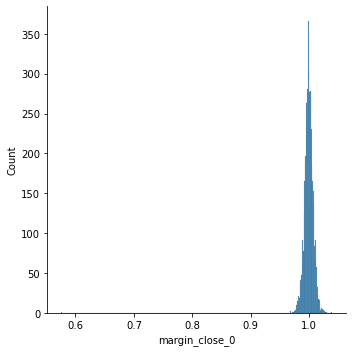

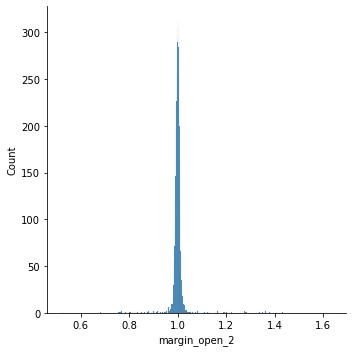

In [11]:
sns.displot(df_half, x="margin_close_0");
sns.displot(df_half, x="margin_open_2");

In [12]:
df_half=df_half.loc[(df_half['margin_close_0']>.98) & (df_half['margin_open_2']>0.98)]
df_half=df_half.loc[(df_half['margin_close_0']<1.02) & (df_half['margin_open_2']<1.02)]

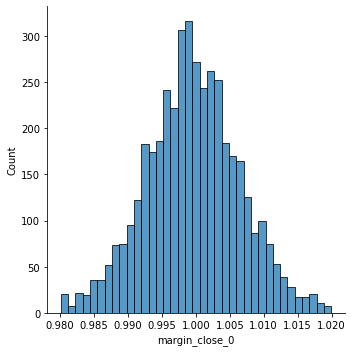

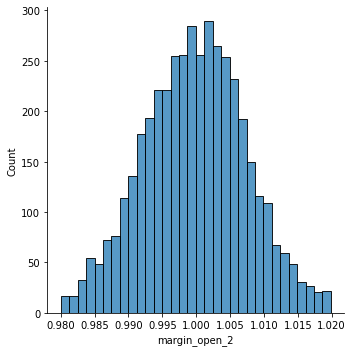

In [13]:
sns.displot(df_half, x="margin_close_0");
sns.displot(df_half, x="margin_open_2");

# TS

In [14]:
df_graph=df_graph.loc[df_graph['time']<=45]
df_graph=df_graph.drop_duplicates()
df_graph_pivoted=df_graph.pivot(index='mid', columns='time', values='graph').add_prefix('G').reset_index()
df_graph_pivoted=df_graph_pivoted.loc[df_graph_pivoted['mid'].isin(df_half['mid'])]
df_graph_pivoted=df_graph_pivoted.dropna()

scaler = StandardScaler()
df_scaled_graph = scaler.fit_transform(df_graph_pivoted.iloc[:, 1:].T).T
df_scaled_graph_rev = scaler.fit_transform((df_graph_pivoted.iloc[:, 1:]*-1).T).T

100%|██████████| 14/14 [57:13<00:00, 245.24s/it]


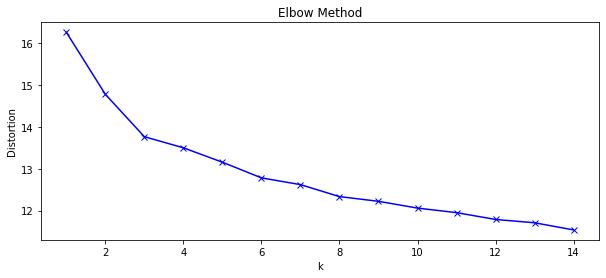

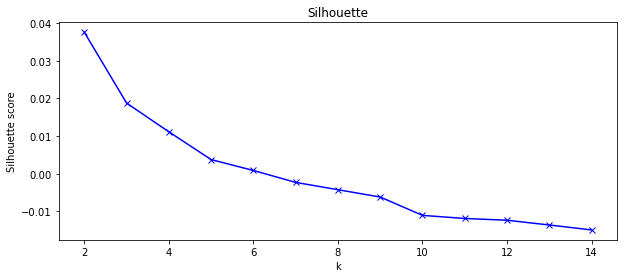

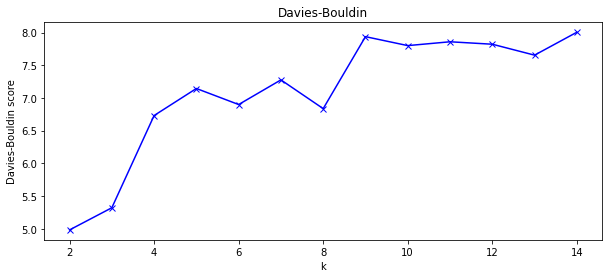

In [15]:
find_kmeans(df_scaled_graph, "dtw", 15)

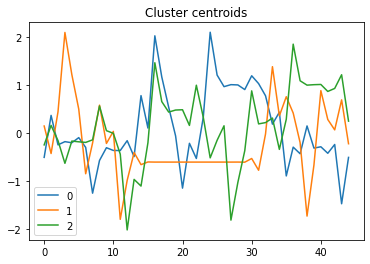

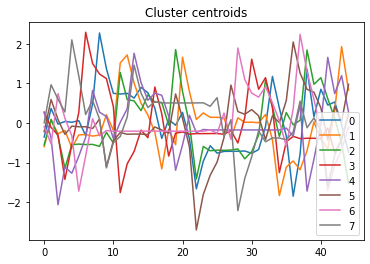

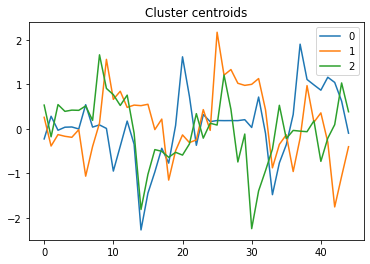

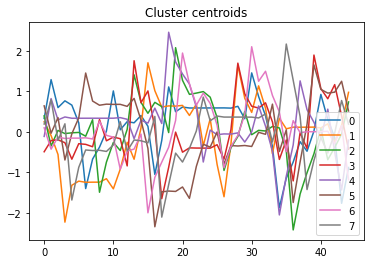

In [21]:
ts_kmeans3 = calc_kmeans(df_scaled_graph, "dtw", 3, 'str')
ts_kmeans8 = calc_kmeans(df_scaled_graph, "dtw", 8, 'str')

ts_kmeans3_rev = calc_kmeans(df_scaled_graph_rev,"dtw",  3, 'rev')
ts_kmeans8_rev = calc_kmeans(df_scaled_graph_rev,"dtw",  8, 'rev')

In [22]:
df_graph_pivoted['clg3'] = ts_kmeans3.predict(df_scaled_graph)
df_graph_pivoted['clg8'] = ts_kmeans8.predict(df_scaled_graph)

df_graph_pivoted['clg3_rev'] = ts_kmeans3_rev.predict(df_scaled_graph_rev)
df_graph_pivoted['clg8_rev'] = ts_kmeans8_rev.predict(df_scaled_graph_rev)

In [23]:
df_half=df_half.loc[df_half['mid'].isin(df_graph_pivoted['mid'])]
df_half=df_half.drop_duplicates(subset=['mid'])
df_graph_pivoted.shape, df_half.shape

((4288, 50), (4288, 36))

In [24]:
df_half=df_half.merge(df_graph_pivoted[['mid','clg3','clg8','clg3_rev','clg8_rev']])

# Duplicate matches and flip home - away

In [25]:
df_home=df_half.copy()
df_home['home']=1
df_away=df_half.copy()
df_away['home']=0

df_away[['graph','goal_d','red_d','yellow_d','penalty_d','subs_d', 'graph_dyn', 'goal_dyn', 'red_dyn', 'yellow_dyn', 'penalty_dyn', 'subs_dyn']]=df_away[['graph','goal_d','red_d','yellow_d','penalty_d','subs_d', 'graph_dyn', 'goal_dyn', 'red_dyn', 'yellow_dyn', 'penalty_dyn', 'subs_dyn']]*-1
df_away['h1_res']=df_away['h1_res'].apply(lambda x: 0 if x==0 else 1 if x==2 else 2)
df_away['h2_res']=df_away['h2_res'].apply(lambda x: 0 if x==0 else 1 if x==2 else 2)
df_away['ft_res']=df_away['ft_res'].apply(lambda x: 0 if x==0 else 1 if x==2 else 2)
df_away=df_away.rename(columns={'h_goal_h1':'a_goal_h1', 'a_goal_h1':'h_goal_h1', 'h_goal_h2':'a_goal_h2', 'a_goal_h2':'h_goal_h2',
       'h_goal_ft':'a_goal_ft', 'a_goal_ft':'h_goal_ft',
       'clg3':'clg3_rev', 'clg3_rev':'clg3', 'clg8_rev':'clg8', 'clg8':'clg8_rev',
       'clh0':'cla0', 'clh1':'cla1', 'clh0':'clh0', 'clh1':'clh1',
       'home_close_0':'away_close_0', 'home_open_2':'away_open_2','away_close_0':'home_close_0', 'away_open_2':'home_open_2'})
df_home=df_home.merge(df_stats_h, on='mid', how='left')
df_away=df_away.merge(df_stats_a, on='mid', how='left')
df_half=pd.concat([df_home, df_away]).reset_index(drop=True)
df_half=df_half.sample(frac=1).reset_index(drop=True)
df_half['htft_changed']=np.where(df_half['h1_res']==df_half['ft_res'],0,1)

In [26]:
print('H1-FT',f1_score(df_half['h1_res'], df_half['ft_res'], average='micro'))
print('H1-H2',f1_score(df_half['h1_res'], df_half['h2_res'], average='micro'))
print('HTFT Changed',df_half['htft_changed'].mean())

H1-FT 0.6031228151945933
H1-H2 0.37520391517128876
HTFT Changed 0.3968771848054067


In [91]:
#df_half=pd.get_dummies(df_half, columns=['h2_res'], prefix=['h2_res'] )
#df_half=pd.get_dummies(df_half, columns=['ft_res'], prefix=['ft_res'] )
cols_odds=['home_close_0','draw_close_0','away_close_0']
cols_info=['mid', 'home', 'h_goal_h1', 'a_goal_h1', 'h_goal_h2', 'a_goal_h2', 'h_goal_ft', 'a_goal_ft','h1_res', 'h2_res','ft_res','htft_changed','home_open_2','draw_open_2','away_open_2']
cols_num=['graph', 'goal_d', 'h_goal_h1', 'a_goal_h1','red_d','yellow_d','penalty_d','subs_d', 'graph_dyn', 'goal_dyn', 'red_dyn', 'yellow_dyn', 'penalty_dyn', 'subs_dyn']+list(cols_stats)+list(cols_stats_diffs)+list(cols_odds)
cols_cat=['home','h1_res', 'clh0', 'clh1', 'cld0', 'cld1', 'cla0', 'cla1','clg3','clg3_rev'] #h1_res
#cols_cat=['home','h1_res', 'clh0', 'clh1', 'cld0', 'cld1', 'cla0', 'cla1','clg8','clg8_rev'] #h1_res
#cols_out=[ 'h2_res_0','h2_res_1','h2_res_2']
#cols_out=[ 'ft_res_0','ft_res_1','ft_res_2']
cols_out=[ 'h2_res','ft_res', 'htft_changed']
df_half[cols_odds]=1/df_half[cols_odds]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_half[cols_num].values)
df_X=pd.concat([pd.DataFrame(data=scaled, columns=cols_num), df_half[cols_cat]], axis=1)
df_X[cols_cat].astype(int)
#df_X=pd.DataFrame(data=scaled, columns=cols_num)
df_y=df_half[cols_out]
df_info=df_half[cols_info]
cat_features=[len(df_X.columns)-2,len(df_X.columns)-1]


In [72]:
#df_X=pd.concat([pd.DataFrame(data=scaled, columns=cols_num), df_half[cols_info+cols_bin]], axis=1).values
#df_y=df_half[cols_out].values

#df_X=pd.concat([pd.DataFrame(data=scaled, columns=cols_num), df_half[cols_info+cols_bin]], axis=1)
#df_y=df_half[cols_out]

In [92]:
train_X, test_X, train_y, test_y, train_info, test_info = train_test_split(df_X, df_y, df_info, test_size=0.3, random_state=42)
validate_X, test_X, validate_y, test_y, validate_info, test_info = train_test_split(test_X, test_y, test_info, test_size=0.5, random_state=42)
print(train_X.shape, train_y.shape, train_info.shape, test_X.shape, test_y.shape ,test_info.shape, validate_X.shape, validate_y.shape ,validate_info.shape)

(6007, 57) (6007, 3) (6007, 15) (1288, 57) (1288, 3) (1288, 15) (1287, 57) (1287, 3) (1287, 15)


In [93]:
target='h2_res'
train_dataset = Pool(data=train_X, label=train_y[target], cat_features=cat_features)
eval_dataset = Pool(data=test_X, label=test_y[target], cat_features=cat_features)
validate_dataset = Pool(data=validate_X, label=validate_y[target], cat_features=cat_features)
model = CatBoostClassifier(iterations=10000, learning_rate=.001, depth=4, loss_function='MultiClass')
model.fit(train_dataset,eval_set=validate_dataset,early_stopping_rounds=50,use_best_model=True, verbose=False)
preds_class = model.predict(eval_dataset)
#preds_proba = model.predict_proba(eval_dataset)

In [94]:
dfr=pd.concat([test_info.reset_index(drop=True),pd.DataFrame(preds_class, columns=['pred_h2'])], axis=1)

In [95]:
target='ft_res'
train_dataset = Pool(data=train_X, label=train_y[target], cat_features=cat_features)
eval_dataset = Pool(data=test_X, label=test_y[target], cat_features=cat_features)
validate_dataset = Pool(data=validate_X, label=validate_y[target], cat_features=cat_features)
model = CatBoostClassifier(iterations=10000, learning_rate=.001, depth=4, loss_function='MultiClass')
model.fit(train_dataset,eval_set=validate_dataset,early_stopping_rounds=50,use_best_model=True, verbose=False)
preds_class = model.predict(eval_dataset)

In [96]:
dfr=pd.concat([dfr.reset_index(drop=True),pd.DataFrame(preds_class, columns=['pred_ft'])], axis=1)

In [97]:
target='htft_changed'
train_dataset = Pool(data=train_X, label=train_y[target], cat_features=cat_features)
eval_dataset = Pool(data=test_X, label=test_y[target], cat_features=cat_features)
validate_dataset = Pool(data=validate_X, label=validate_y[target], cat_features=cat_features)
model = CatBoostClassifier(iterations=10000, learning_rate=.001, depth=4)
model.fit(train_dataset,eval_set=validate_dataset,early_stopping_rounds=50,use_best_model=True)
preds_class = model.predict(eval_dataset)
preds_proba = model.predict_proba(eval_dataset)

.5s
9014:	learn: 0.5250207	test: 0.5422150	best: 0.5422150 (9014)	total: 2m 39s	remaining: 17.5s
9015:	learn: 0.5250176	test: 0.5422142	best: 0.5422142 (9015)	total: 2m 39s	remaining: 17.5s
9016:	learn: 0.5250171	test: 0.5422143	best: 0.5422142 (9015)	total: 2m 39s	remaining: 17.4s
9017:	learn: 0.5250156	test: 0.5422145	best: 0.5422142 (9015)	total: 2m 39s	remaining: 17.4s
9018:	learn: 0.5250140	test: 0.5422149	best: 0.5422142 (9015)	total: 2m 39s	remaining: 17.4s
9019:	learn: 0.5250085	test: 0.5422172	best: 0.5422142 (9015)	total: 2m 39s	remaining: 17.4s
9020:	learn: 0.5250027	test: 0.5422147	best: 0.5422142 (9015)	total: 2m 39s	remaining: 17.4s
9021:	learn: 0.5250004	test: 0.5422149	best: 0.5422142 (9015)	total: 2m 40s	remaining: 17.3s
9022:	learn: 0.5249953	test: 0.5422166	best: 0.5422142 (9015)	total: 2m 40s	remaining: 17.3s
9023:	learn: 0.5249944	test: 0.5422171	best: 0.5422142 (9015)	total: 2m 40s	remaining: 17.3s
9024:	learn: 0.5249913	test: 0.5422150	best: 0.5422142 (9015)	tota

In [98]:
dfr=pd.concat([dfr.reset_index(drop=True),pd.DataFrame(preds_proba, columns=['pred_ch1','pred_ch0'])], axis=1)
dfr=pd.concat([dfr.reset_index(drop=True),pd.DataFrame(preds_class, columns=['pred_ch'])], axis=1)

In [99]:
dfr['h1_diff']=(dfr['h_goal_h1']-dfr['a_goal_h1']).abs()
dfr['h2_acc']=np.where(dfr['h2_res']==dfr['pred_h2'],1,0)
dfr['ft_acc']=np.where(dfr['ft_res']==dfr['pred_ft'],1,0)
dfr['ch_acc']=np.where(dfr['htft_changed']==dfr['pred_ch'],1,0)

In [100]:
dfr.groupby(['home','h1_diff'])[['htft_changed','pred_ch','h2_acc','ft_acc','ch_acc','pred_ch1','pred_ch0']].mean()

htft_changed   pred_ch    h2_acc    ft_acc    ch_acc  pred_ch1  \
home h1_diff                                                                   
0    0.0          0.650190  0.980989  0.471483  0.448669  0.646388  0.368665   
     1.0          0.298182  0.007273  0.447273  0.701818  0.701818  0.710782   
     2.0          0.102041  0.000000  0.530612  0.897959  0.897959  0.870752   
     3.0          0.000000  0.000000  0.285714  1.000000  1.000000  0.880616   
     4.0          0.000000  0.000000  0.500000  1.000000  1.000000  0.849659   
     6.0          0.000000  0.000000  0.000000  1.000000  1.000000  0.905170   
1    0.0          0.669039  0.978648  0.548043  0.540925  0.683274  0.370070   
     1.0          0.334694  0.012245  0.440816  0.669388  0.669388  0.724288   
     2.0          0.116505  0.000000  0.466019  0.883495  0.883495  0.858505   
     3.0          0.000000  0.000000  0.444444  1.000000  1.000000  0.901125   
     4.0          0.000000  0.000000  0.500000  1.000000  1.000000  0.904272   

              pred_ch0  
home h1_diff            
0    0.0      0.631335  
     1.0      0.289218  
     2.0      0.129248  
     3.0      0.119384  
     4.0      0.150341  
     6.0      0.094830  
1    0.0      0.629930  
     1.0      0.275712  
     2.0      0.141495  
     3.0      0.098875  
     4.0      0.095728

In [105]:
#print('macro',f1_score(test_y.values, preds_class, average='macro'))
print('micro',f1_score(test_y.values, preds_class, average='micro'))
print('H1-H2',f1_score(test_info['h1_res'], test_info['h2_res'], average='micro'))
#print('weighted',f1_score(test_y.values, preds_class, average='weighted'))

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets

In [82]:
dfr.to_csv('pred3.csv')

In [ ]:
# design network
model = keras.Sequential()
model.add(layers.Dense(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat.min()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
df.loc[df['mid']==8699223]

## Res 

In [101]:
dfr=dfr[['mid', 'home', 'h_goal_h1', 'a_goal_h1', 'h1_res', 'ft_res', 'home_open_2', 'draw_open_2', 'away_open_2', 'pred_ft', 'ft_acc']]
dfr['odds']=dfr.apply(lambda x: x.draw_open_2 if x.pred_ft==0 else x.home_open_2 if x.pred_ft==1 else x.away_open_2, axis=1)

dfr['odds_keep']=dfr.apply(lambda x: x.draw_open_2 if x.h1_res==0 else x.home_open_2 if x.h1_res==1 else x.away_open_2, axis=1)
dfr['keep_acc']=dfr.apply(lambda x: 1 if x.h1_res==x.ft_res else 0, axis=1)

dfr['prf_ft']=np.where(dfr['ft_acc']==1,dfr['odds']-1,-1)
dfr['prf_keep']=np.where(dfr['keep_acc']==1,dfr['odds_keep']-1,-1)

dfr['diff']=dfr['h_goal_h1']-dfr['a_goal_h1']

dfr['oddsr']=pd.qcut(dfr.odds, 10)
dfr['oddsr_keep']=pd.qcut(dfr.odds_keep, 10)

In [102]:
display(colorize(total(dfr, 'home', 'keep')))

home,COUNT,ACC,PRF,ROI
0.000000,646.000000,0.592879,22.270000,0.034474
1.000000,642.000000,0.560748,-24.780000,-0.038598
Total,1288.000000,nan,-2.510000,-0.001949


In [103]:
display(colorize(total(dfr, 'home', 'ft')))

home,COUNT,ACC,PRF,ROI
0.000000,646.000000,0.633127,3.490000,0.005402
1.000000,642.000000,0.654206,26.810000,0.041760
Total,1288.000000,nan,30.300000,0.023525


In [109]:
display(colorize(total(dfr, 'pred_ft', 'ft')))

pred_ft,COUNT,ACC,PRF,ROI
0.000000,179.000000,0.407821,7.280000,0.040670
1.000000,582.000000,0.683849,16.510000,0.028368
2.000000,527.000000,0.679317,6.510000,0.012353
Total,1288.000000,nan,30.300000,0.023525


In [111]:
display(colorize(total(dfr[dfr['home']==1], 'pred_ft', 'ft')))
display(colorize(total(dfr[dfr['home']==0], 'pred_ft', 'ft')))

pred_ft,COUNT,ACC,PRF,ROI
0.000000,82.000000,0.463415,15.200000,0.185366
1.000000,378.000000,0.711640,18.380000,0.048624
2.000000,182.000000,0.620879,-6.770000,-0.037198
Total,642.000000,nan,26.810000,0.041760


pred_ft,COUNT,ACC,PRF,ROI
0.000000,97.000000,0.360825,-7.920000,-0.081649
1.000000,204.000000,0.632353,-1.870000,-0.009167
2.000000,345.000000,0.710145,13.280000,0.038493
Total,646.000000,nan,3.490000,0.005402


In [114]:
display(colorize(total(dfr[dfr['home']==1], 'diff', 'ft')))
display(colorize(total(dfr[dfr['home']==0], 'diff', 'ft')))

diff,COUNT,ACC,PRF,ROI
-4.000000,2.000000,1.000000,0.310000,0.155000
-3.000000,3.000000,1.000000,1.490000,0.496667
-2.000000,41.000000,0.804878,-0.620000,-0.015122
-1.000000,88.000000,0.568182,-10.930000,-0.124205
0.000000,281.000000,0.540925,37.040000,0.131815
1.000000,157.000000,0.726115,-3.390000,-0.021592
2.000000,62.000000,0.935484,2.680000,0.043226
3.000000,6.000000,1.000000,0.140000,0.023333
4.000000,2.000000,1.000000,0.090000,0.045000
Total,642.000000,nan,26.810000,0.041760


diff,COUNT,ACC,PRF,ROI
-6.000000,1.000000,1.000000,0.020000,0.020000
-4.000000,1.000000,1.000000,0.060000,0.060000
-3.000000,5.000000,1.000000,0.140000,0.028000
-2.000000,64.000000,0.953125,2.990000,0.046719
-1.000000,146.000000,0.753425,10.200000,0.069863
0.000000,263.000000,0.448669,-12.800000,-0.048669
1.000000,129.000000,0.643411,4.980000,0.038605
2.000000,34.000000,0.794118,-2.360000,-0.069412
3.000000,2.000000,1.000000,0.050000,0.025000
4.000000,1.000000,1.000000,0.210000,0.210000


In [89]:
display(colorize(total(dfr, 'oddsr_keep', 'keep')))

oddsr_keep,COUNT,ACC,PRF,ROI
"(1.0090000000000001, 1.08]",186.000000,0.978495,4.320000,0.023226
"(1.08, 1.182]",158.000000,0.873418,-1.610000,-0.010190
"(1.182, 1.308]",171.000000,0.789474,-3.410000,-0.019942
"(1.308, 1.47]",173.000000,0.757225,7.290000,0.042139
"(1.47, 1.82]",171.000000,0.619883,-0.080000,-0.000468
"(1.82, 2.4]",183.000000,0.437158,-12.080000,-0.066011
"(2.4, 2.62]",170.000000,0.411765,6.700000,0.039412
"(2.62, 2.86]",162.000000,0.382716,7.480000,0.046173
"(2.86, 3.25]",179.000000,0.312849,-7.940000,-0.044358
"(3.25, 25.0]",164.000000,0.225610,-12.550000,-0.076524


In [90]:
display(colorize(total(dfr, 'oddsr', 'ft')))

oddsr,COUNT,ACC,PRF,ROI
"(1.0090000000000001, 1.08]",186.000000,0.978495,4.320000,0.023226
"(1.08, 1.18]",161.000000,0.875776,-1.130000,-0.007019
"(1.18, 1.29]",169.000000,0.792899,-3.310000,-0.019586
"(1.29, 1.42]",175.000000,0.777143,9.380000,0.053600
"(1.42, 1.6]",176.000000,0.693182,8.500000,0.048295
"(1.6, 1.8]",164.000000,0.548780,-10.780000,-0.065732
"(1.8, 2.06]",179.000000,0.519553,1.870000,0.010447
"(2.06, 2.32]",168.000000,0.416667,-12.000000,-0.071429
"(2.32, 2.54]",168.000000,0.392857,-7.040000,-0.041905
"(2.54, 25.0]",171.000000,0.409357,24.720000,0.144561
